In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
import optuna
import re


In [46]:
# Step 1: Load the dataset
df = pd.read_csv('/Vehicle-Price-Prediction.csv')

In [47]:
# Step 2: Display basic info about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1002 non-null   object 
 1   description     946 non-null    object 
 2   make            1002 non-null   object 
 3   model           1002 non-null   object 
 4   year            1002 non-null   int64  
 5   price           979 non-null    float64
 6   engine          1000 non-null   object 
 7   cylinders       897 non-null    float64
 8   fuel            995 non-null    object 
 9   mileage         968 non-null    float64
 10  transmission    1000 non-null   object 
 11  trim            1001 non-null   object 
 12  body            999 non-null    object 
 13  doors           995 non-null    float64
 14  exterior_color  997 non-null    object 
 15  interior_color  964 non-null    object 
 16  drivetrain      1002 non-null   object 
dtypes: float64(4), int64(1), object(1

In [35]:
print(df.describe())

              year          price   cylinders      mileage       doors
count  1002.000000     979.000000  897.000000   968.000000  995.000000
mean   2023.916168   50202.985700    4.975474    69.033058    3.943719
std       0.298109   18700.392062    1.392526   507.435745    0.274409
min    2023.000000       0.000000    0.000000     0.000000    2.000000
25%    2024.000000   36600.000000    4.000000     4.000000    4.000000
50%    2024.000000   47165.000000    4.000000     8.000000    4.000000
75%    2024.000000   58919.500000    6.000000    13.000000    4.000000
max    2025.000000  195895.000000    8.000000  9711.000000    5.000000


In [48]:
# Step 3: Check for missing values
print(df.isnull().sum())

name                0
description        56
make                0
model               0
year                0
price              23
engine              2
cylinders         105
fuel                7
mileage            34
transmission        2
trim                1
body                3
doors               7
exterior_color      5
interior_color     38
drivetrain          0
dtype: int64


In [49]:
# Step 4: Drop unnecessary columns
df.drop(columns=['description', 'name', 'exterior_color', 'interior_color'], inplace=True)

In [66]:
# # Step 5: Handle missing values (fill with mode or median)
# df['cylinders'].fillna(df['cylinders'].median(), inplace=True)
# df['mileage'].fillna(df['mileage'].median(), inplace=True)
# df.dropna(inplace=True)
# Step 5: Handle missing values (fill with mode, median, or drop)
df['mileage'].fillna(df['mileage'].median(), inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)  # Fill all numeric NaNs with median
df.dropna(inplace=True)  # Drop remaining missing values


<ipython-input-66-acb4ef5b966c>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['mileage'].fillna(df['mileage'].median(), inplace=True)


In [67]:
# # Step 6: Convert categorical variables to numerical using one-hot encoding
# # Convert 'cylinders' to numerical by extracting digits
# df['cylinders'] = df['cylinders'].astype(str).apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else np.nan)
# df['cylinders'].fillna(df['cylinders'].median(), inplace=True)

# df = pd.get_dummies(df, columns=['make', 'model', 'fuel', 'transmission', 'trim', 'body', 'drivetrain'], drop_first=True)

# Convert 'cylinders' and 'engine' to numerical by extracting digits
df['cylinders'] = df['cylinders'].astype(str).apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else np.nan)
df['cylinders'].fillna(df['cylinders'].median(), inplace=True)

df['engine'] = df['engine'].astype(str).apply(lambda x: float(re.search(r'\d+(\.\d+)?', x).group()) if re.search(r'\d+(\.\d+)?', x) else np.nan)
df['engine'].fillna(df['engine'].median(), inplace=True)



<ipython-input-67-f2267bbb464d>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cylinders'].fillna(df['cylinders'].median(), inplace=True)
<ipython-input-67-f2267bbb464d>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [68]:
# Step 7: Define features and target variable
X = df.drop(columns=['price'])  # Feature set
y = df['price']  # Target variable

# Ensure target variable has no NaN values
y.dropna(inplace=True)
X = X.loc[y.index]  # Keep only corresponding rows in X


In [69]:
# Step 8: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
# Step 9: Initialize models
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
xgb = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)

In [71]:
# Step 10: Train models
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
gb.fit(X_train, y_train)


GradientBoostingRegressor(max_depth=10, random_state=42)

In [72]:
# Step 11: Make predictions
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)
y_pred_gb = gb.predict(X_test)

In [73]:
# Step 12: Function to evaluate model performance
def evaluate_model(y_test, y_pred, model_name):
    print(f'--- {model_name} Performance ---')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
    print(f'R2 Score: {r2_score(y_test, y_pred)}\n')

In [74]:
# Step 13: Evaluate models
evaluate_model(y_test, y_pred_rf, 'Random Forest')
evaluate_model(y_test, y_pred_xgb, 'XGBoost')
evaluate_model(y_test, y_pred_gb, 'Gradient Boosting')


--- Random Forest Performance ---
MAE: 4983.2545917411035
RMSE: 7504.898407896123
R2 Score: 0.7790392036569931

--- XGBoost Performance ---
MAE: 3818.5538809856967
RMSE: 6202.528100378121
R2 Score: 0.8490743440318541

--- Gradient Boosting Performance ---
MAE: 3713.3500439455916
RMSE: 5984.630292189717
R2 Score: 0.8594922613993414



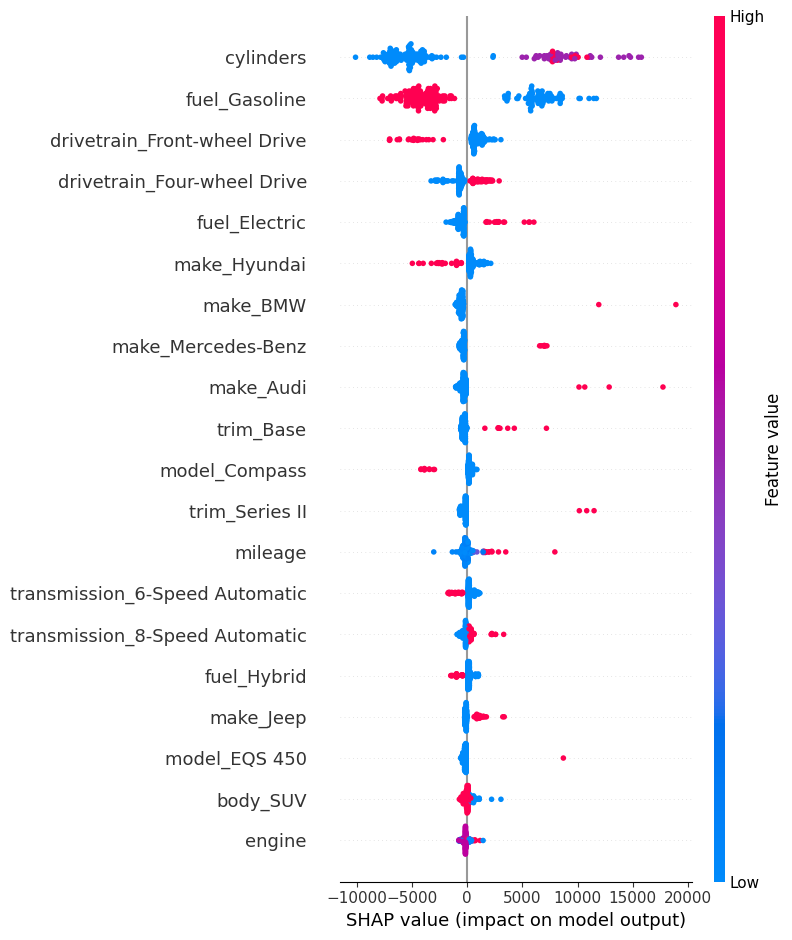

In [75]:
# Step 14: Feature Importance using SHAP
explainer = shap.Explainer(rf)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [76]:
# Step 15: Hyperparameter tuning using Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)

    model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print('Best Hyperparameters:', study.best_params)


[I 2025-03-30 16:12:00,816] A new study created in memory with name: no-name-526a242f-7942-4e59-b44c-b3b7ffcefc6f
[I 2025-03-30 16:12:08,100] Trial 0 finished with value: 0.7518804772624791 and parameters: {'n_estimators': 53, 'max_depth': 16, 'learning_rate': 0.1857611739923359}. Best is trial 0 with value: 0.7518804772624791.
[I 2025-03-30 16:12:13,465] Trial 1 finished with value: 0.7561243979351572 and parameters: {'n_estimators': 134, 'max_depth': 12, 'learning_rate': 0.0693961636412088}. Best is trial 1 with value: 0.7561243979351572.
[I 2025-03-30 16:12:28,161] Trial 2 finished with value: 0.7452461082634615 and parameters: {'n_estimators': 244, 'max_depth': 20, 'learning_rate': 0.05165121474933981}. Best is trial 1 with value: 0.7561243979351572.
[I 2025-03-30 16:12:33,655] Trial 3 finished with value: 0.7530244465385423 and parameters: {'n_estimators': 337, 'max_depth': 9, 'learning_rate': 0.29895322348530046}. Best is trial 1 with value: 0.7561243979351572.
[I 2025-03-30 16:1

Best Hyperparameters: {'n_estimators': 335, 'max_depth': 7, 'learning_rate': 0.09115670876424546}


In [77]:
# Step 16: Retrain the best model
best_model = XGBRegressor(**study.best_params, random_state=42)
best_model.fit(X_train, y_train)
y_best_pred = best_model.predict(X_test)
evaluate_model(y_test, y_best_pred, 'Optimized XGBoost')

--- Optimized XGBoost Performance ---
MAE: 3782.7108014614428
RMSE: 6273.852504220184
R2 Score: 0.8455833238757728



In [78]:
# Step 17: Cross-Validation (K-Fold)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_scores = cross_val_score(best_model, X_train, y_train, scoring='r2', cv=kfold)
print(f'K-Fold Cross Validation Scores: {kfold_scores}')
print(f'Average Cross Validation Score: {np.mean(kfold_scores)}')


K-Fold Cross Validation Scores: [0.65866335 0.87704952 0.6936149  0.88062426 0.73837817]
Average Cross Validation Score: 0.7696660425914607


In [79]:
# Step 18: Stacking Ensemble Model
stacking_model = StackingRegressor(
    estimators=[('rf', rf), ('xgb', xgb), ('gb', gb)], final_estimator=XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42))
stacking_model.fit(X_train, y_train)
y_stack_pred = stacking_model.predict(X_test)
evaluate_model(y_test, y_stack_pred, 'Stacking Ensemble Model')

--- Stacking Ensemble Model Performance ---
MAE: 5103.80079096704
RMSE: 7576.082483636041
R2 Score: 0.7748276917658405



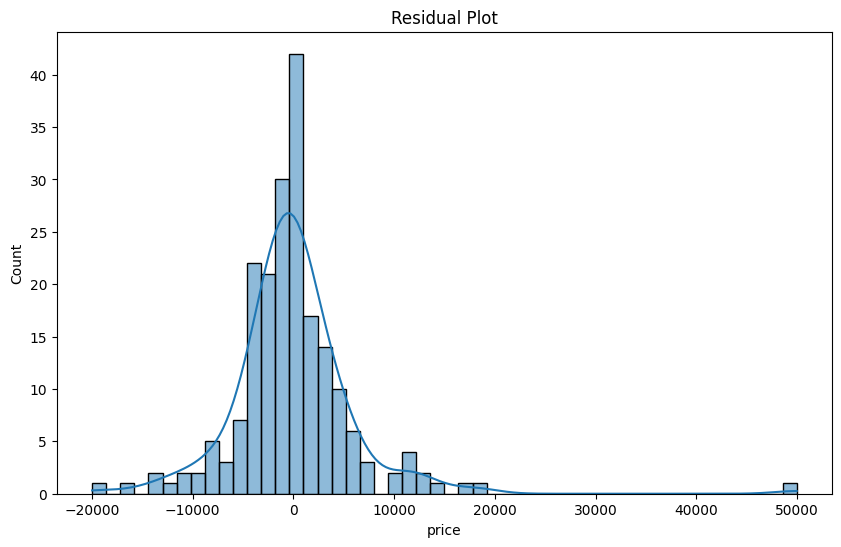

In [80]:
# Step 19: Final visualizations
plt.figure(figsize=(10, 6))
sns.histplot(y_test - y_best_pred, bins=50, kde=True)
plt.title('Residual Plot')
plt.show()

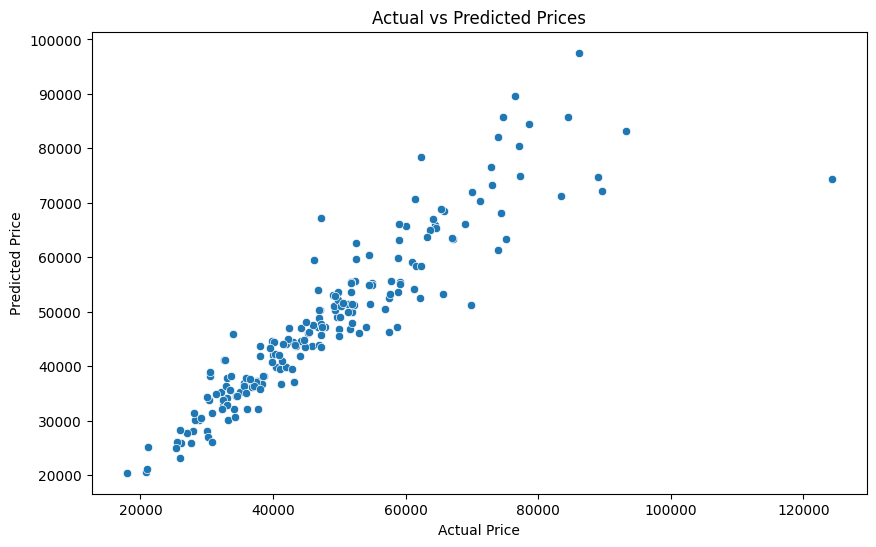

In [81]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_best_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()